This notebook uses a single tracker to generate a set of frequencies for each salmon individual.

In [183]:
import sys  
sys.path.insert(0, 'C:\\Users\\espebh\\Documents\\Thesis\\code_ver2')
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from helpers import m
from helpers.prob_utils import prob_random_clsf
from helpers.sine_fitting_utils import fit_sine
import math

from scipy.signal import savgol_filter


In [184]:
# Choose tracker
path = 'C:\\Users\\espebh\\Documents\\Thesis\\data\\Results\\Results from full pipeline in tank 9\\salmon_jaw_distances_280922_t9_c8_f2000\\trackers'
name = '280922_t9_c8_1t_s6_f_5000_7000_2023391853.pkl'

In [185]:
# Load tracker
infile = open(os.path.join(path, name),'rb')
trackers = pickle.load(infile)


In [186]:
# This function removes time series points with obvious erroneous detections.
# LABEL_NAMES = ['ljaw', 'ujaw', 'eye', 'rjaw', 'rpec', 'head_body_intercept', 'dfin']
# keep_jaw_indices: Indices of the time series that contain correct jaw classifications. [0, 1, 2, 6, 7, ...].
# keep_cl_indices: Indices of the time series that contain correct rpec, head_body_intercept, dfin and eye detections. Referencing the correct jaw indices, hence to get the correct class points from the initial time series,
# the correct indexing would be ts[keep_jaw_indices][keep_cl_indices]. 
# keypoints: Keypoint detections from keypoint rcnn saved in the trackers. [np.array(7,2), np.array(7,2), ...]

def review_kp_positions(keypoints, debug = False):
    keep_jaw_indices = []
    keep_cl_indices = []
    for i in range(len(keypoints)):
        kps = keypoints[i]

        # find swimming direction based on relative location of head-body-intercept and dorsal fin.
        if kps[5][0] >= kps[6][0]:
            dir = 'sr'
        elif kps[5][0] < kps[6][0]:
            dir = 'sl'

        # Check if the salmon is swimming towards the camera based on relative location of eye and head-body-intercept.
        if dir == 'sr' and kps[2][0] < kps[5][0]:
            dir = 'front'
            if debug: print('Salmon at index ', i, ' is recorded from the front')
        elif dir == 'sl' and kps[2][0] > kps[5][0]:
            dir = 'front'
            if debug: print('Salmon at index ', i, ' is recorded from the front')

        # Examine whether the vertical keypoint position is erroneous
        # 1. Check if ujaw is lower than ljaw.
        # 2. Check if ljaw is clearly above the eye
        # 3. Check if dfin is above rpec
        ujaw_wrong_ver_pos = kps[1][1] > kps[0][1]
        ljaw_wrong_ver_pos = kps[2][1] - kps[0][1] > 5
        rpec_wrong_ver_pos = kps[5][1] > kps[4][1]

        # Examine whether the horizontal keypoint position is erroneous.
        # The jaws are erroneous if any keypoints are more aneterior on the fish than the jaw detections.
        # The classifications additionally requires correct horizontal placement of eye, rpec and dfin.
        if dir == 'sl':
            ljaw_wrong_hor_pos = kps[0][0] >= kps[2][0] or kps[0][0] >= kps[3][0] or kps[0][0] >= kps[4][0] or kps[0][0] >= kps[5][0] or kps[0][0] >= kps[6][0]
            ujaw_wrong_hor_pos = kps[1][0] >= kps[2][0] or kps[1][0] >= kps[3][0] or kps[1][0] >= kps[4][0] or kps[1][0] >= kps[5][0] or kps[1][0] >= kps[6][0]
            eye_wrong_hor_pos = kps[2][0] > kps[4][0] or kps[2][0] > kps[6][0]
            rpec_wrong_hor_pos = kps[4][0] > kps[6][0]
            hbi_wrong_hor_pos = kps[5][0] > kps[6][0]
        if dir == 'sr':
            ljaw_wrong_hor_pos = kps[0][0] <= kps[2][0] or kps[0][0] <= kps[3][0] or kps[0][0] <= kps[4][0] or kps[0][0] <= kps[5][0] or kps[0][0] <= kps[6][0]
            ujaw_wrong_hor_pos = kps[1][0] <= kps[2][0] or kps[1][0] <= kps[3][0] or kps[1][0] <= kps[4][0] or kps[1][0] <= kps[5][0] or kps[1][0] <= kps[6][0]
            eye_wrong_hor_pos = kps[2][0] < kps[4][0] or kps[2][0] < kps[6][0]
            rpec_wrong_hor_pos = kps[4][0] < kps[6][0]
            hbi_wrong_hor_pos = kps[5][0] < kps[6][0]

        # Flags to specify wheteher the current index should be removed from the timeseries
        idx_err_for_jaws = 0
        idx_err_for_cl = 0

        # Remove datapoint if the horizontal or vertical location is wrong
        if dir != 'front' and (ljaw_wrong_hor_pos or ujaw_wrong_hor_pos):
            idx_err_for_jaws = 1
            idx_err_for_cl = 1
            if debug: print('Wrong horizontal jaw positions at index ', i)
        if dir != 'front' and (eye_wrong_hor_pos or rpec_wrong_hor_pos or hbi_wrong_hor_pos):
            idx_err_for_cl = 1
            if debug: print('Wrong horizontal keypoint positions at index ', i)

        if ujaw_wrong_ver_pos or ljaw_wrong_ver_pos: 
            idx_err_for_jaws = 1
            idx_err_for_cl = 1
            if debug: print('Wrong vertical jaw positions at index ', i)
        if rpec_wrong_ver_pos:
            idx_err_for_cl = 1
            if debug: print('Wrong vertical keypoint positions at index ', i)

        # Remove datapoint if the upper jaw is further away from the eye in the y direction, than in the x direction
        # This is the case if the upper jaw is detected wrong.
        elif  np.linalg.norm(kps[2][0] - kps[1][0])/(np.linalg.norm(kps[2][1] - kps[1][1])+np.finfo(float).eps) < 1:
            idx_err_for_jaws = 1
            idx_err_for_cl = 1
            if debug: print('Upper jaw too far away from the eye at index ', i)

        if idx_err_for_jaws == 0:
            keep_jaw_indices.append(i)
        if dir != 'front' and idx_err_for_cl == 0:
            keep_cl_indices.append(len(keep_jaw_indices)-1)

    return keep_jaw_indices, keep_cl_indices


11


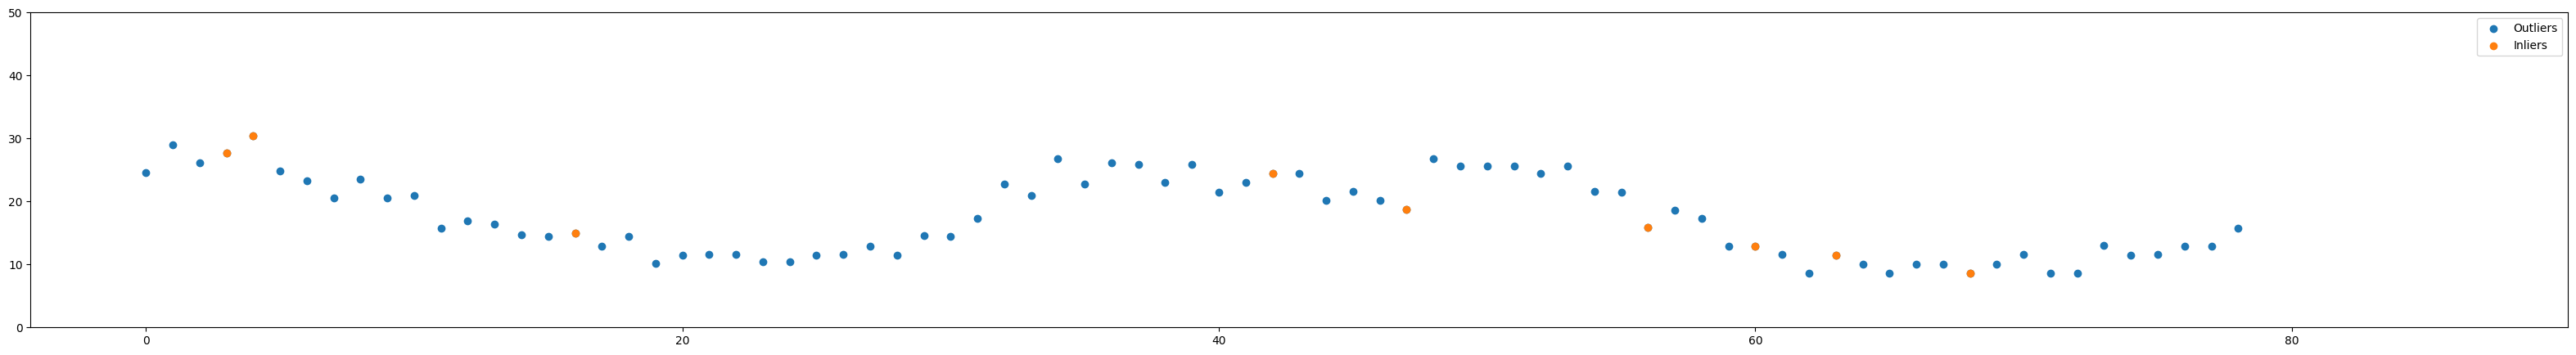

In [187]:
# Test review_kp_positions

nr = 9
print(trackers[nr].id)

x = trackers[nr].frames
y = trackers[nr].full_dists
sf = x[0]

keep_jaw_indices, keep_cl_indices = review_kp_positions(trackers[nr].keypoints.copy(), debug = False)

fig, ax = plt.subplots(1, 1, figsize=(40, 5))
plt.scatter((np.array(x)-sf), y, label = 'Outliers')
plt.scatter((np.array(x)[np.array(keep_jaw_indices)[keep_cl_indices]]-sf), np.array(y)[np.array(keep_jaw_indices)[keep_cl_indices]], label = 'Inliers')
#plt.ylim(0,max(np.array(y)[keep_indices]))
plt.ylim(0,50)
plt.legend()


In [188]:
# Input: Trackers from a video sequence
# Output freq_dict: Dictionary with a list of frequensies for each individual fish. {'Aaron': [1.357659211812543, 1.3544284373646365, ...], 'Baasha': [...], ...}
# Output plot_dict: A dictionary with information that can be used to plot and debug the frequency extraction algorithm.

# fish_names: Alphabetically ordered names of the fish in the tank
# type: The mouth pose metric used. Can be 'euc' for euclidean distance, 'ang' for angular opening and 'wrp' for euclidean distance after homogenous transform.
# length_of_ts: The length of the timeseries that the jaw pose evolutions are cut into. One length_of_ts timeseries equals one frequency in freq_dict.
# advance_per_ts: The number of datapoints between the start of two consecutive time series.
# min_val_cls_cnt: The time series will only be accepted if more than min_val_cls_cnt*100 percent of the classifications are held by the most common fish.
# min_cls_cert: Let k be the largest class in a tracker, and prob be the probability of a random classifier finding more than k of one class for a given frame number. Then, prob must be lower than cls_cert for the tracker to be accepted.
# max_freq_std: If the frequency standard deviation of the final sine fitting is above max_freq_std, the time series is rejected.
# max_frame_diff_in_ts: The maximum frame count difference between the first and last point in a time series
# min_inl_cnt: The minimum number of inliers in a time series

def generate_frequency_dicts(trackers, 
                            fish_names,
                            classes_to_fish_map,
                            type = 'euc', 
                            length_of_ts = 100, 
                            advance_per_ts = 20,
                            min_val_cls_cnt = 1/3,
                            min_cls_cert = 0.01, 
                            max_freq_std = 0.05,
                            max_frame_diff_in_ts = 200,
                            min_inl_cnt = 55,
                            debug = False):

    # Define frequencies for line search
    test_freq = [0.8, 1.2, 1.6, 2, 2.4]

    # Define output dicts, one for storing information for plotting, one for storing frequency information
    plot_dicts = []
    freq_dict =  dict([(x,[]) for x in (fish_names)])

    # Iterate over all trackers
    for tracker in trackers:
        # Extract time and mouth opening lists from trackers
        x = np.array(tracker.frames).astype(int)/m.FRAMES_PER_SECOND
        if type == 'euc':
            y = np.array(tracker.full_dists)
        elif type == 'ang':
            y = np.array(tracker.ang_dists)
            y[y<-180] = y[y<-180]+360
            y[y>180] = y[y>180]-360
        elif type == 'wrp':
            y = np.array(tracker.warped_dists)

        # Remove if the data arrays are too short
        if len(x) < length_of_ts:
            continue
        
        # Remove points if the keypoint configuration is clearly erroneous
        keep_jaw_indices, keep_cl_indices = review_kp_positions(tracker.keypoints)
        x, y, cl= np.array(x)[keep_jaw_indices], np.array(y)[keep_jaw_indices], np.array(tracker.clses)[:,0].astype(int)[keep_jaw_indices]
        one_hot_cl = [False]*len(cl)
        for i in range(len(one_hot_cl)):
            if i in keep_cl_indices:
                one_hot_cl[i] = True

        # Remove if the data arrays are too short
        if len(x) < length_of_ts:
            continue
        
        # Make data arrays. Each data array have shape 4xlength_of_ts.
        data = np.stack([x, y, cl, one_hot_cl])
        split = []
        for i in range(0,data.shape[1],advance_per_ts):
            split.append(data[:,i:i+length_of_ts])
            
        # Iterate over all timeseries
        for d in split:
            # Early rejectance of short trackers
            if d.shape[1]<length_of_ts:
                continue

            # split the data array into individual arrays
            xs, ys, cl, one_hot_cl = d[0,:], d[1,:], d[2,:], d[3,:]

            # Fit sine
            b_inl_cnt = 0
            b_config = []
            for freq in test_freq:
                y_sine, popt, perr, inl = fit_sine(xs, ys, freq, thresh_gain = 1)
                if sum(inl) > b_inl_cnt and perr[0] < max_freq_std:
                    b_config = [y_sine, popt, perr, inl]
                    b_inl_cnt = sum(inl)
            if len(b_config) > 0:
                y_sine, popt, perr, inl = b_config
            else:
                if debug: print('Could not fit sinusoid for box', tracker.id)
                continue

            # Find the most common fish
            fish_cnt = []
            for fish in classes_to_fish_map:
                cnt = 0
                for c in fish:
                    cnt = cnt + list(np.array(cl)[one_hot_cl==True]).count(c)
                fish_cnt.append(cnt)
            fish_name = fish_names[np.argmax(np.array(fish_cnt))]
            num_frames_in_max_cl = np.max(np.array(fish_cnt))
            num_cl_pred = len(np.array(cl)[one_hot_cl==True])

            # Check rate of correct class predictions
            if prob_random_clsf(num_frames_in_max_cl, num_cl_pred, prob = 1/2) > min_cls_cert:
                if debug: print('Probability that ', fish_name, ' is picked at random is ', prob_random_clsf(num_frames_in_max_cl, num_cl_pred, prob = 1/2))
            # Check number of correct class predictions
            elif num_cl_pred < min_val_cls_cnt*length_of_ts:
                if debug: print('The number of accurate class predictions for ', fish_name, ' are ', num_cl_pred)
            # Check time difference between first and last frame
            elif xs[-1]-xs[0] > max_frame_diff_in_ts/m.FRAMES_PER_SECOND:
                if debug: print('The length between first and last frame are ', xs[-1]-xs[0], ' for box ', tracker.id)
            # Check number of inliers
            elif sum(inl) < min_inl_cnt:
                if debug: print('The number of inliers are ', sum(inl), ' for box ', tracker.id)
            # Store information in output dicts
            else:
                freq_dict[fish_name].append(popt[0])
                plot_dicts.append({ 'full_arr': np.stack([xs, ys]),
                            'sine_arr': np.stack([xs, y_sine]),
                            'inl_arr': np.stack(([xs[inl], ys[inl]])),
                            'name': fish_name,
                            'box': tracker.id,
                            'freq': popt[0],
                            'std': perr[0],
                            'amp': popt[1],
                            'rs': sum(perr),
                            'one_hot': one_hot_cl})

    return freq_dict, plot_dicts

In [189]:
tracker_names = list(sorted(os.listdir(path)))

plot_dict = dict([(x,[]) for x in (m.FISH_NAMES_T9)])
save_dicts = []


infile = open(os.path.join(path, name),'rb')
trackers = pickle.load(infile)
infile.close()
save_dict, plot_dict = generate_frequency_dicts(trackers, m.FISH_NAMES_T9, m.CLASSES_TO_FISH_MAP_T9, type='euc', debug=True)
save_dicts.append(save_dict)
print('Done with tracker ')

c:\Users\espebh\Documents\Thesis\code_ver2\dat_gen_th\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


The number of inliers are  50  for box  0
The number of inliers are  50  for box  0
The number of accurate class predictions for  Caiphas  are  19
The number of accurate class predictions for  Caiphas  are  28
The number of inliers are  53  for box  6
The number of inliers are  50  for box  6
The number of inliers are  51  for box  6
The number of inliers are  44  for box  13
The number of inliers are  52  for box  13
Could not fit sinusoid for box 12
The number of inliers are  52  for box  12
Could not fit sinusoid for box 17
Could not fit sinusoid for box 17
Could not fit sinusoid for box 17
Probability that  Caiphas  is picked at random is  0.08708557363530645
Probability that  Caiphas  is picked at random is  0.1279375397680269
Could not fit sinusoid for box 24
The number of inliers are  50  for box  24
The number of inliers are  51  for box  24
The number of inliers are  53  for box  24
The number of inliers are  54  for box  24
The number of inliers are  46  for box  27
Could not

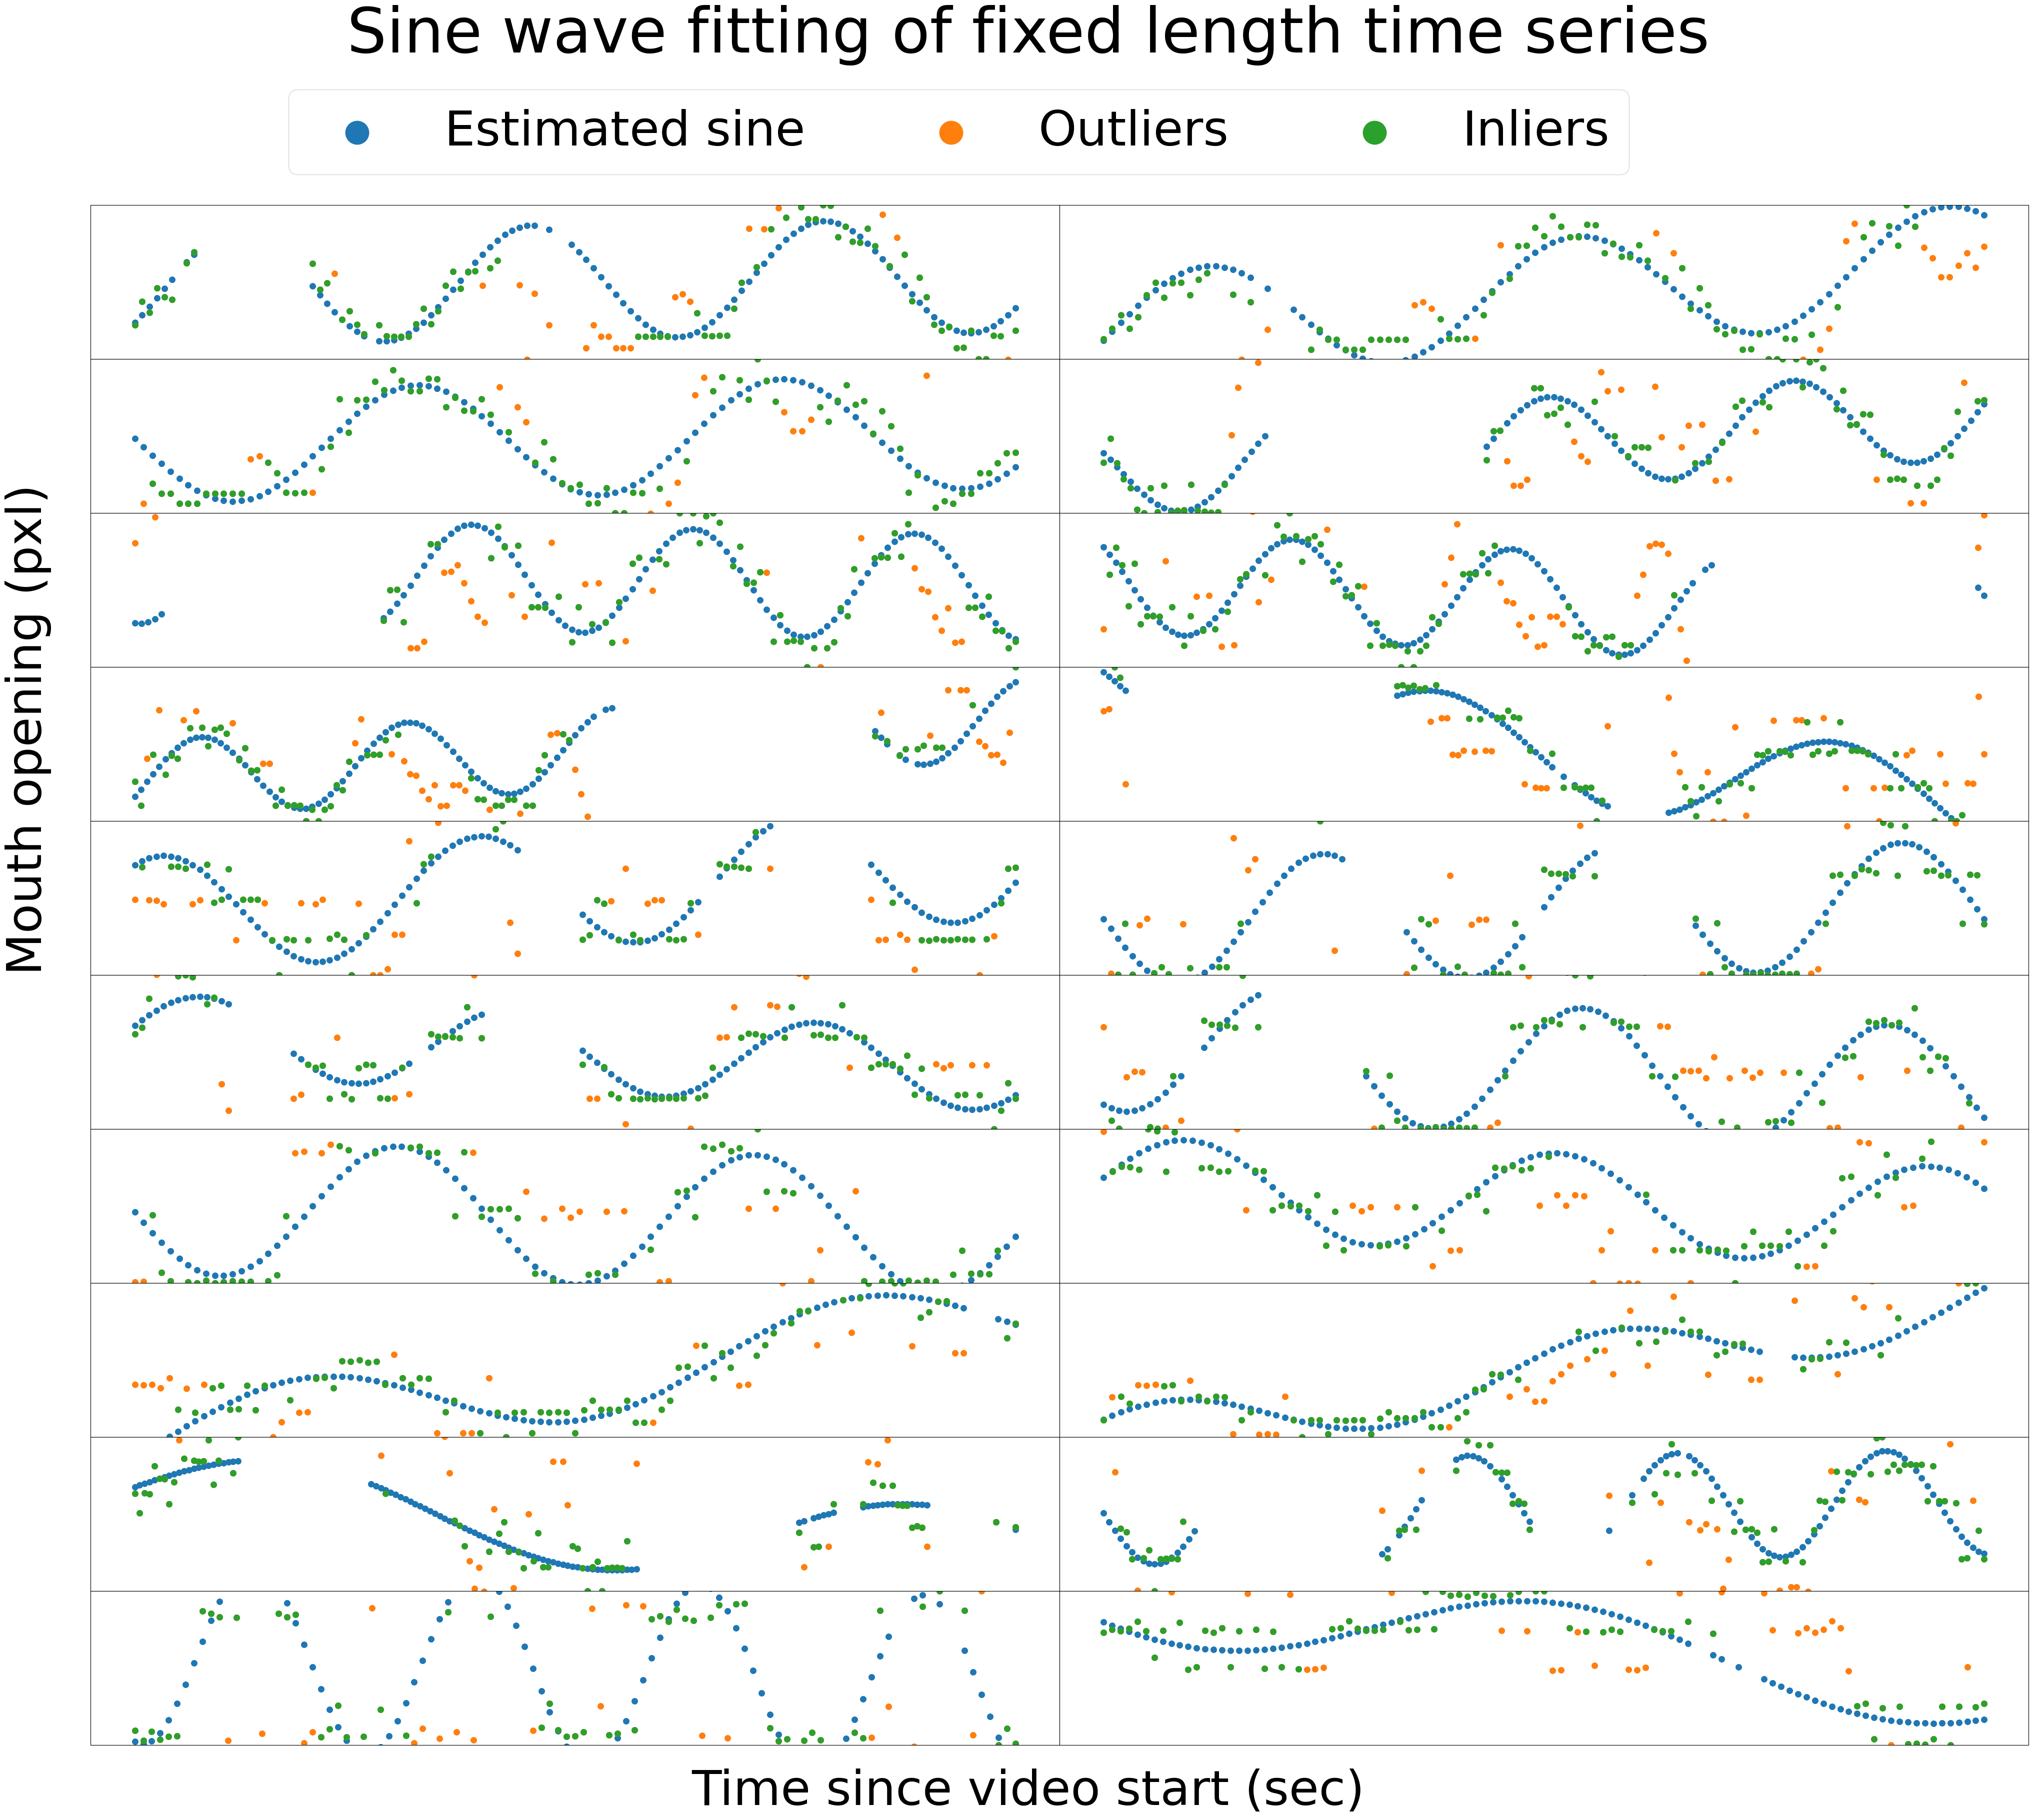

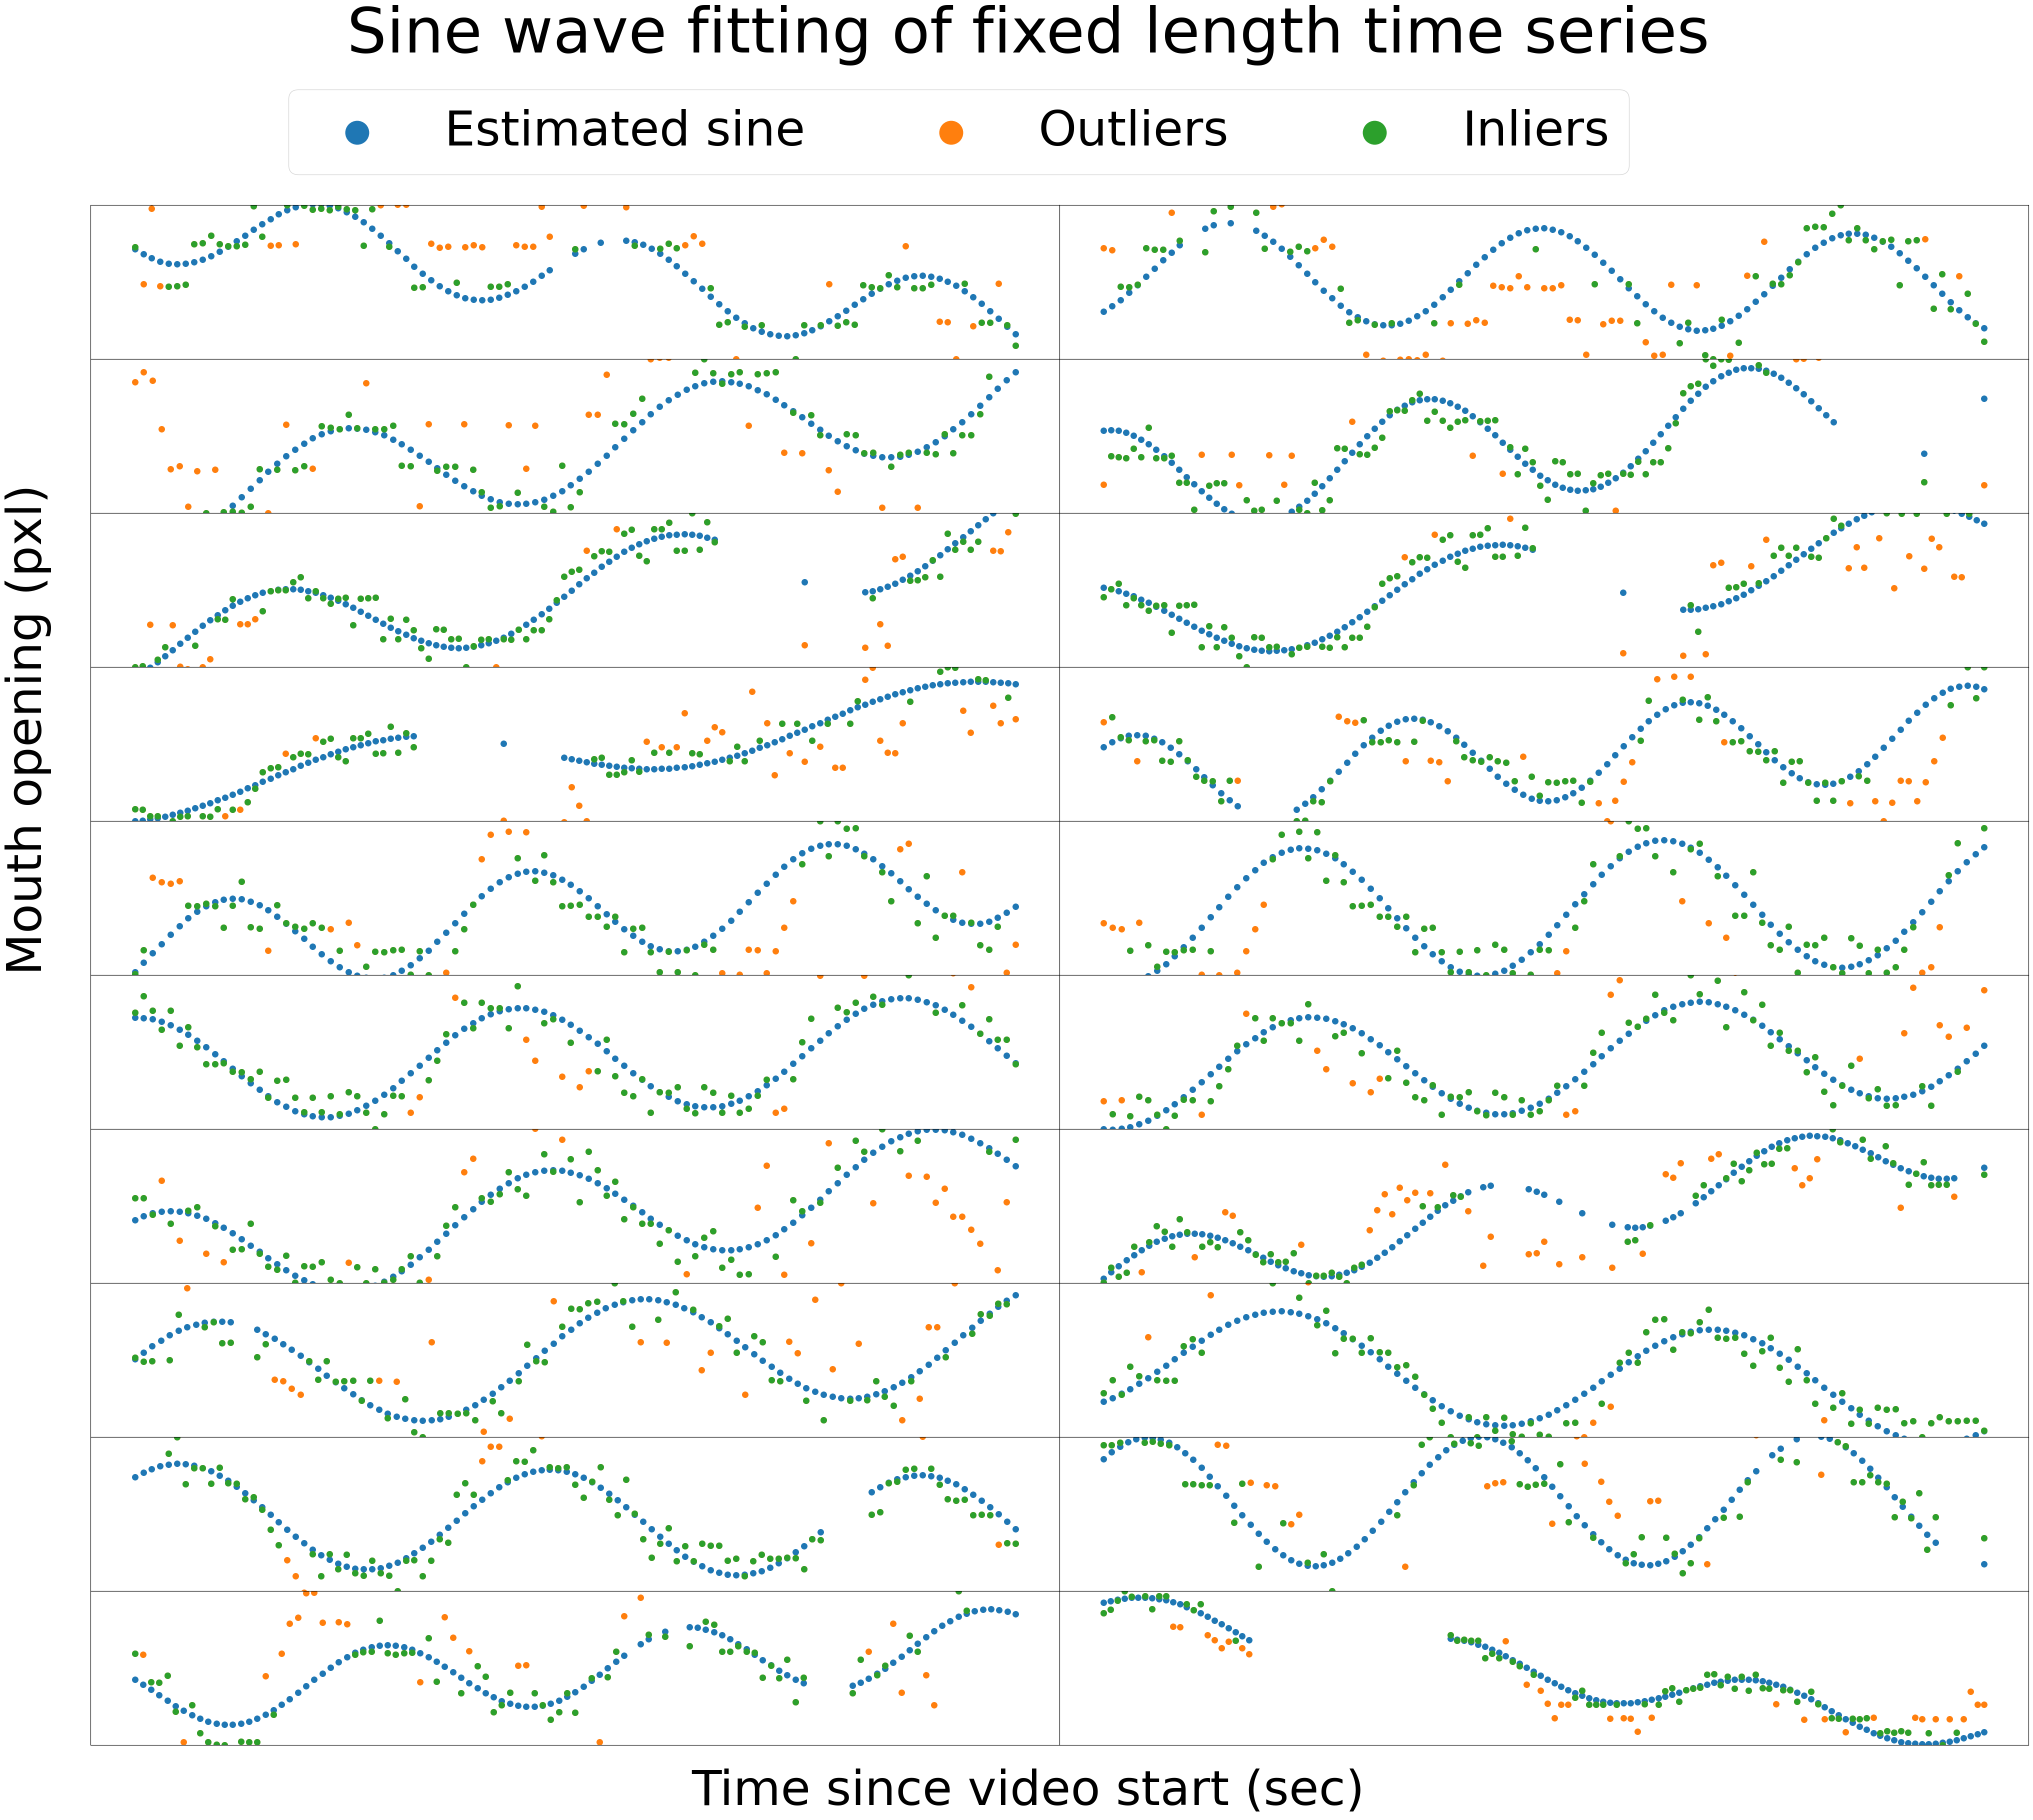

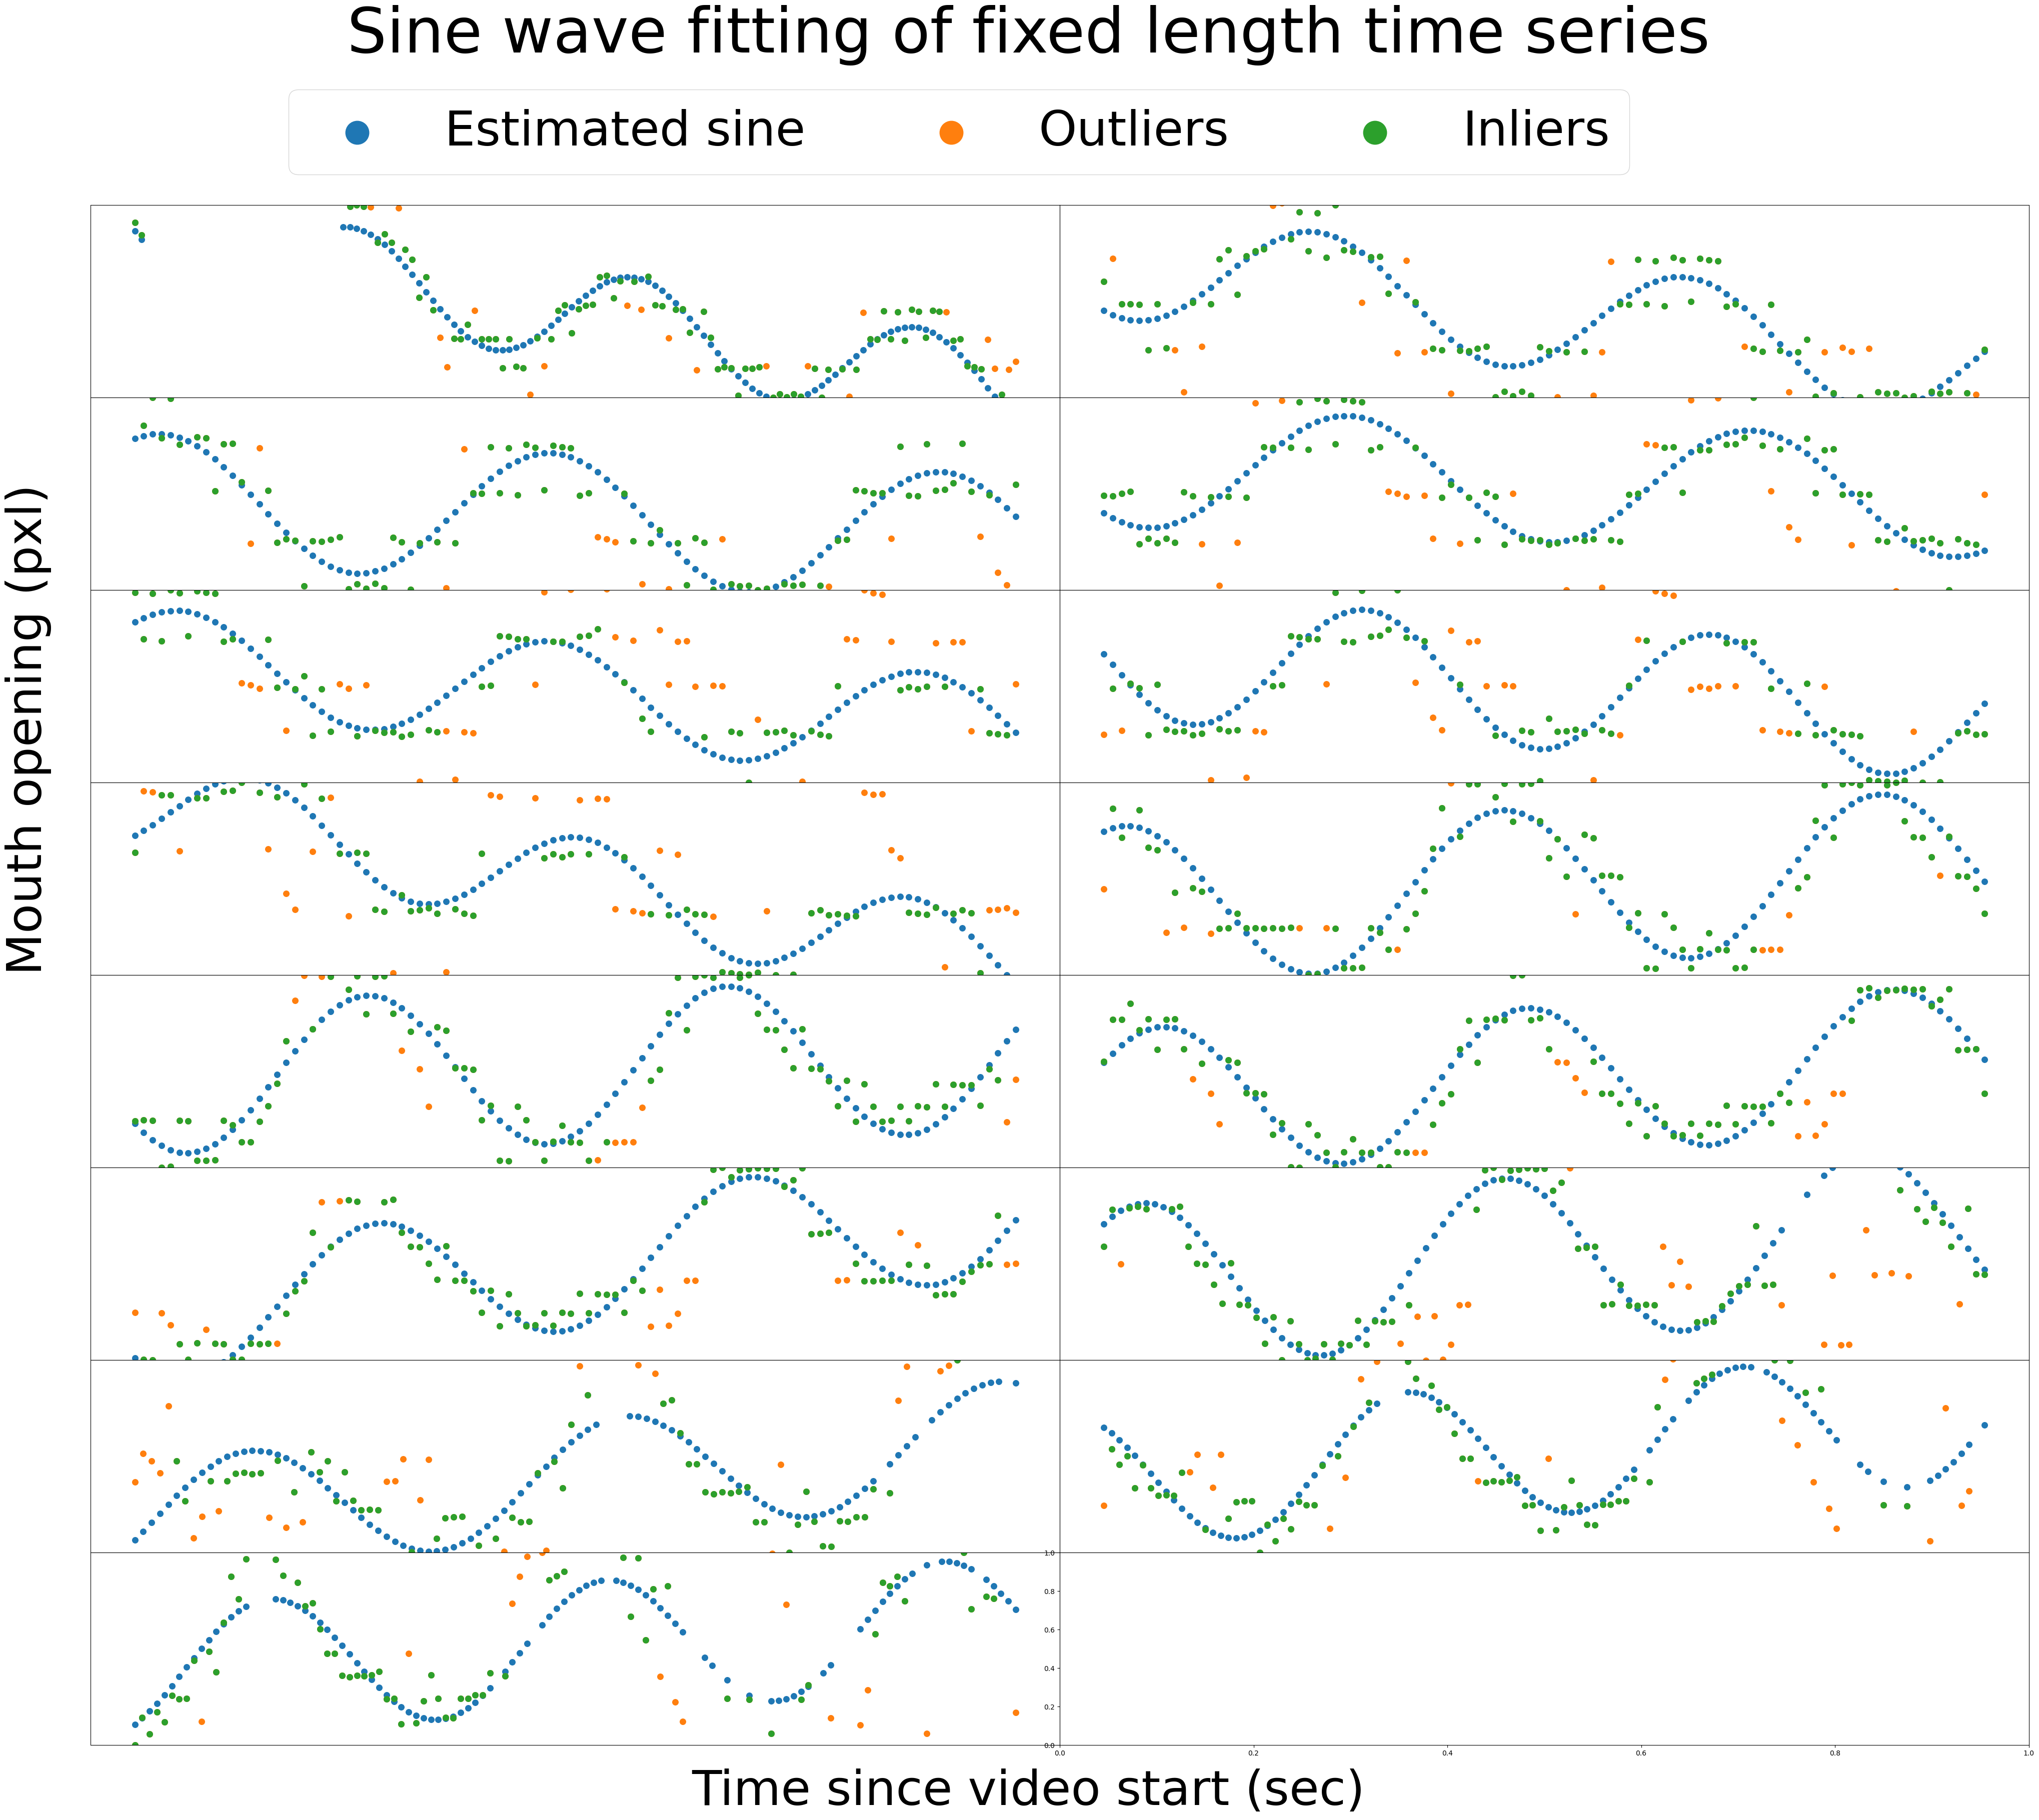

In [190]:
num_plot_dicts = len(plot_dict)
num_pd_per_page = 20
num_pages = math.ceil(num_plot_dicts/num_pd_per_page)

for page in range(num_pages):
    if page < num_pages-1:
        num_col = 2
        num_rows = math.ceil(num_pd_per_page/num_col)
        fig, ax = plt.subplots(num_rows, num_col, figsize=(50, 2*num_pd_per_page))
    else:
        num_col = 2
        num_rows = math.ceil(num_plot_dicts%num_pd_per_page/num_col)
        fig, ax = plt.subplots(num_rows, num_col, figsize=(50, 2*num_pd_per_page))
    fig.subplots_adjust(wspace=0, hspace=0)

    for i in range(num_rows):
        for j in range(num_col):
            pd_idx = page*num_pd_per_page + num_col*i+j
            if pd_idx < len(plot_dict):
                ax[i][j].scatter(plot_dict[pd_idx]['sine_arr'][0], plot_dict[pd_idx]['sine_arr'][1], label = 'Estimated sine', s=70)
                ax[i][j].scatter(plot_dict[pd_idx]['full_arr'][0], plot_dict[pd_idx]['full_arr'][1], label = 'Outliers', s=70)
                ax[i][j].scatter(plot_dict[pd_idx]['inl_arr'][0], plot_dict[pd_idx]['inl_arr'][1], label = 'Inliers', s=70)
                #ax[i][j].set_title('Box nr: ' + str(plot_dict[pd_idx]['box']) + ', Name: ' + str(plot_dict[pd_idx]['name']) + ', Sine freq: ' + str(round(plot_dict[pd_idx]['freq'], 2)), fontdict = {'fontsize': 10})
                ax[i][j].set_ylim(np.min(np.array(plot_dict[pd_idx]['inl_arr'][1])), np.max(np.array(plot_dict[pd_idx]['inl_arr'][1])))
                #ax[i][j].set_ylabel('Mouth opening (pxl)')
                #ax[i][j].set_xlabel('Time since video start (sec)')
                #ax[i][j].legend()
                ax[i][j].axes.get_xaxis().set_ticks([])
                ax[i][j].axes.get_yaxis().set_ticks([])
    fig.legend(['Estimated sine', 'Outliers', 'Inliers'], fontsize = 70, ncols = 3, bbox_to_anchor=(0.75, 0.95), markerscale=4)
    fig.text(0.5, 0.08, 'Time since video start (sec)', ha='center', fontsize = 70)
    fig.text(0.1, 0.5, 'Mouth opening (pxl)', ha='center', rotation='vertical', fontsize = 70)
    fig.suptitle('Sine wave fitting of fixed length time series', fontsize = 90)


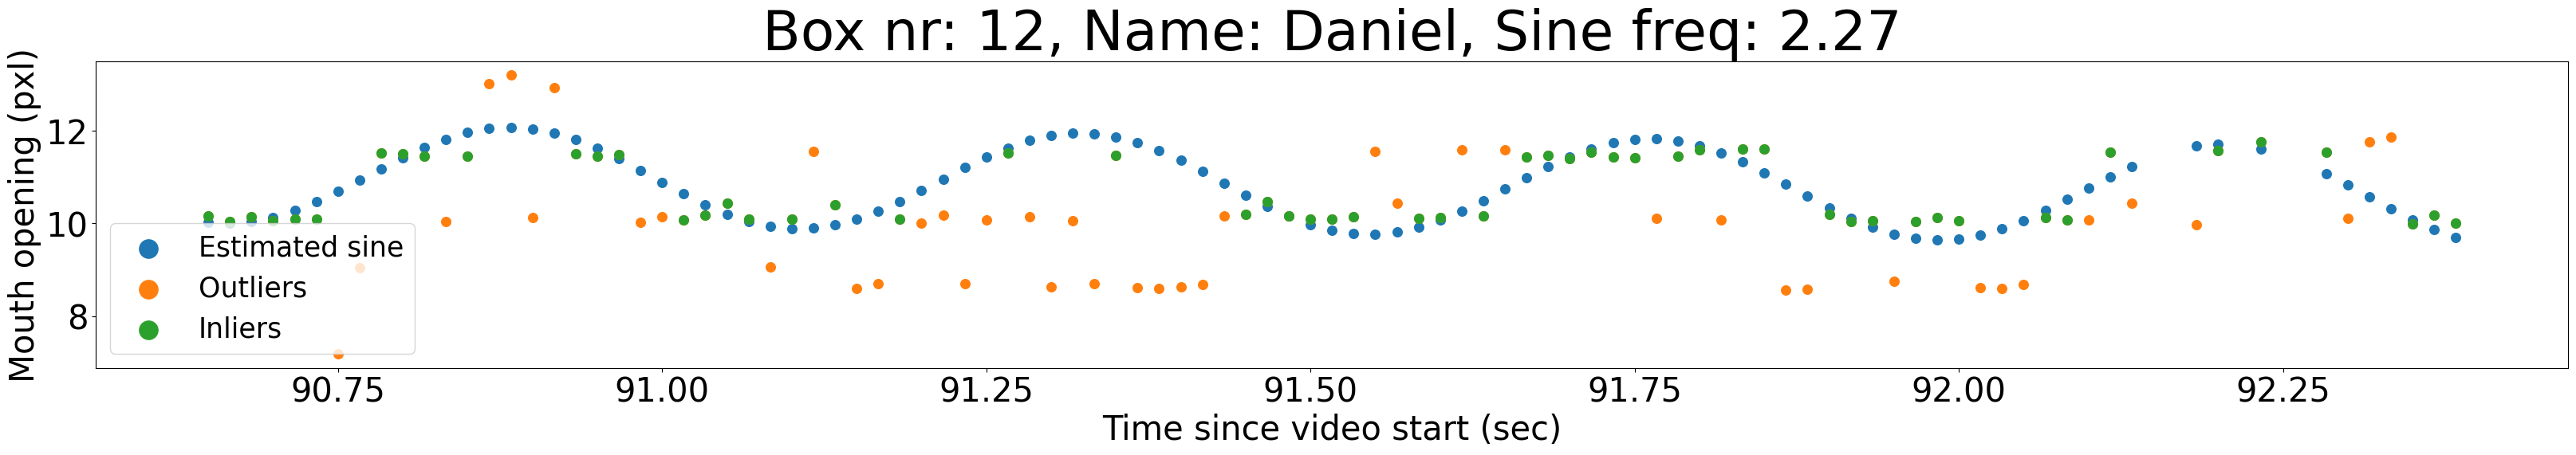

In [199]:

fig, ax = plt.subplots(1, 1, figsize=(40, 5))
fig.subplots_adjust(wspace=0, hspace=0.4)
nr = 18


ax.scatter(plot_dict[nr]['sine_arr'][0], plot_dict[nr]['sine_arr'][1], label = 'Estimated sine', s=70)
ax.scatter(plot_dict[nr]['full_arr'][0], plot_dict[nr]['full_arr'][1], label = 'Outliers', s=70)
ax.scatter(plot_dict[nr]['inl_arr'][0], plot_dict[nr]['inl_arr'][1], label = 'Inliers', s=70)
ax.set_title('Box nr: ' + str(plot_dict[nr]['box']) + ', Name: ' + str(plot_dict[nr]['name']) + ', Sine freq: ' + str(round(plot_dict[nr]['freq'], 2)), fontdict = {'fontsize': 50})
#ax.set_ylim(np.min(np.array(plot_dict[nr]['inl_arr'][1])), np.max(np.array(plot_dict[nr]['inl_arr'][1])))
ax.set_ylabel('Mouth opening (pxl)', fontsize = 30)
ax.set_xlabel('Time since video start (sec)', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.legend(fontsize = 25, markerscale = 2)


{'Aaron': [1.5164169621296208, 1.4023648622954543, 1.462746618694211, 1.8176163389857416, 1.7809802399224801, 1.480344183533822, 1.3937878568493005, 1.3745904184516753, 1.4008542968816957, 1.4690374649004405, 1.6233525622621798], 'Baasha': [1.2271935327100953], 'Caiphas': [1.6487600168732215, 1.822887327134855, 1.7050606869267042, 1.772212440254367, 1.4679142567276933], 'Daniel': [2.2732315708502187, 0.7289016173855422, 1.6776093915083068, 1.6253260287659548, 1.4412454231306933, 1.4128816574107432, 1.1482068565431935, 1.09004659586261, 0.828080210765031, 1.3818482959368639, 1.4725572753993037, 1.440789647899513, 1.369075786545101, 1.326736789046313, 1.4418556663678719, 1.5370458080864446, 1.6254351801412765], 'Ebed-Melech': [1.234242964834313, 1.3694853719429645], 'Hosea': [0.8341806721896836, 1.3627647872025146, 1.4963380821408243, 1.40798792928606, 1.5146217990947037, 1.4947800769662285, 1.4371033520665972, 0.9347326780379714, 1.147282040573614, 1.414211814996122, 1.4867142234382922,

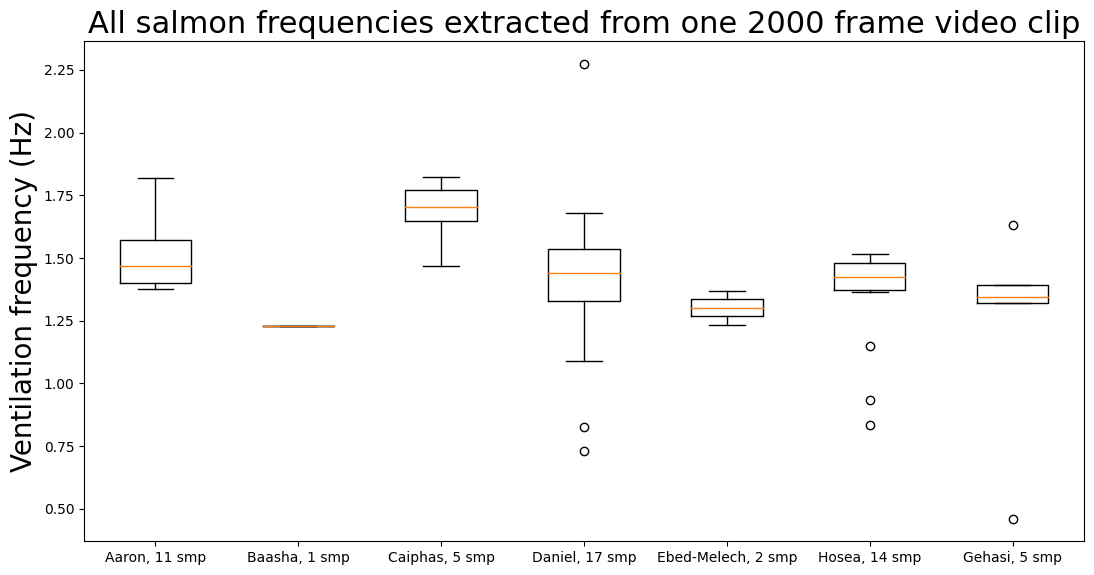

In [192]:
import numpy as np 
import matplotlib.pyplot as plot 


fig = plot.figure(figsize =(10, 5)) 
ax = fig.add_axes([0, 0, 1, 1]) 
data= []
legends = []
print(save_dict)
for fish in save_dict.keys():
    data.append(save_dict[fish])
    legends.append(fish + ', ' + str(len(save_dict[fish])) + ' smp')
ax.boxplot(data, labels = legends)
ax.set_ylabel('Ventilation frequency (Hz)', fontsize = 20)
ax.set_title('All salmon frequencies extracted from one 2000 frame video clip', fontsize = 22)


plot.show()
